In [21]:
from itertools import combinations, permutations
import numpy as np
import scipy as sp
from scipy.constants import e
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('TempiMillikan.txt', names=['ID', 'tempi', 'distanza', 'ddp', 'T'], skiprows=1)
#df.drop('T', axis=1, inplace=True) #la temperatura è sempre la stessa, non serve una colonna
df['distanza']=df['distanza']*1e-3

In [3]:
temp=24 #temperatura misurata
vis = pd.read_csv('viscosità.csv', names=['T', 'viscosità'])
vis['viscosità']=vis['viscosità']*1e-5

In [4]:
modello_viscosità = LinearRegression()
modello_viscosità.fit(vis['T'].to_numpy().reshape(-1,1), vis['viscosità'].to_numpy().reshape(-1,1))
viscosità = modello_viscosità.predict([[temp]])[0,0]

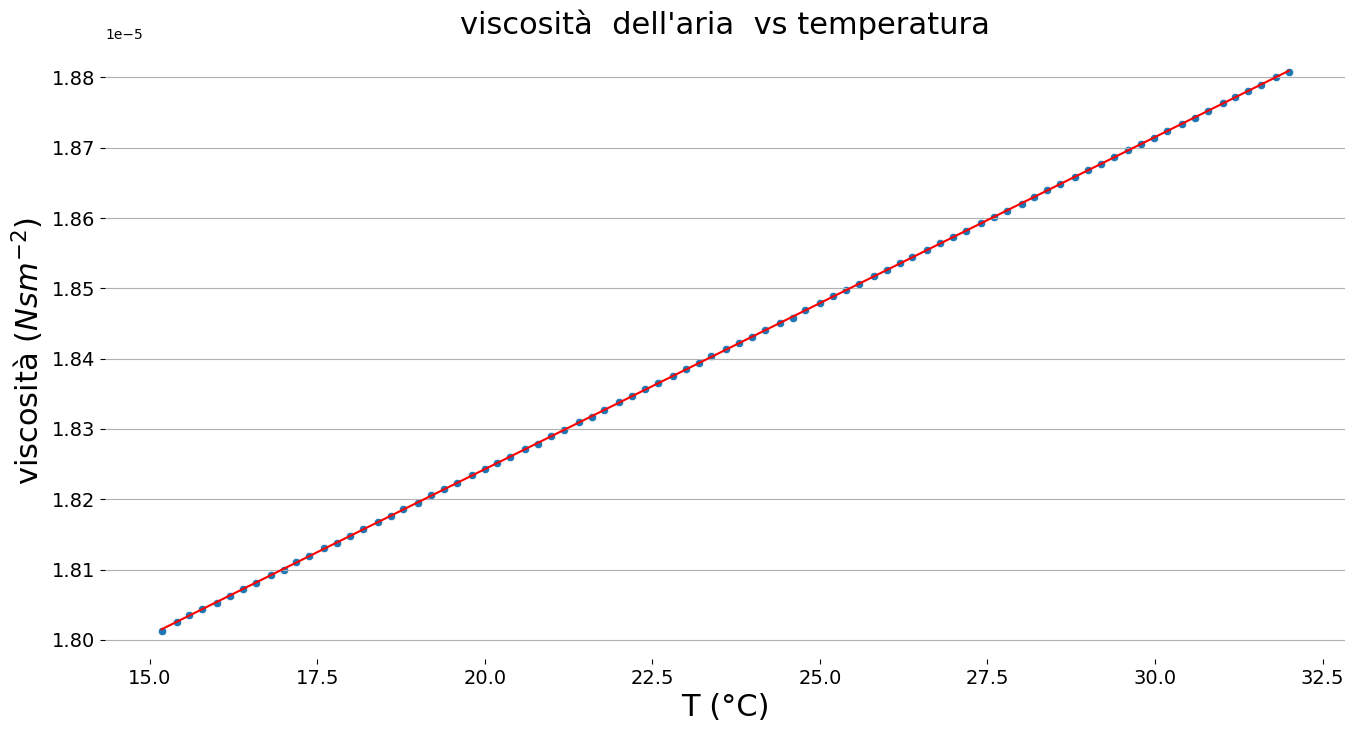

In [5]:
y=modello_viscosità.predict(vis['T'].to_numpy().reshape(-1,1)).flatten()
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (16,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
sns.scatterplot(vis, x='T', y='viscosità', ax=ax1)
sns.lineplot(x=vis['T'], y=y, c='red')
ax1.set_xlabel('T (°C)', fontsize = 22)
ax1.set_ylabel("viscosità ($Nsm^{-2}$)", fontsize = 22)
ax1.set_title('viscosità  dell\'aria  vs temperatura', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)

In [6]:
p=1.01e5 #pascal
g=9.8
rho=886.0 #dendità olio kg/m3
b=0.0822e-2 #pascal / metri
err_x=0.05e-3 #metri
d=7.6e-3 #distanza tra le armature del condensatore

In [7]:
df['moto']=df['tempi'].apply(lambda x : 'salita' if x>0 else 'discesa')
data=df.groupby(['ID', 'moto']).mean()
data['velocità']=np.abs(data['distanza']/data['tempi'])
data['delta tempi']=df.groupby(['ID', 'moto'])['tempi'].agg(np.ptp)/2 #ptp calcola la differenza fra valore massimo e minimo
data['err velocità']=np.sqrt((err_x/data['tempi'])**2 + (data['distanza']*data['delta tempi']/data['tempi']**2)**2)
data['err rel vel']=data['err velocità']/data['velocità']
data=data.unstack()
data['V']=data['ddp']['salita']
data.drop('ddp', axis=1, inplace=True)
data['temp']=data['T']['salita']
data.drop('T', axis=1, inplace=True)
data['vis']=modello_viscosità.predict(data['temp'].to_numpy().reshape(-1,1)).flatten()
data['raggio']=-b/(2*p)+np.sqrt((b/(2*p))**2 + 9*data['vis']*(data['velocità']['discesa'])/2/rho/g)
data['err raggio']=9/4*data['vis']/rho/g/(data['raggio']+b/(2*p))*data['err velocità']['discesa']
data['carica']=4/3*np.pi*data['raggio']**3*rho*g*d/data['V']*(1+data['velocità']['salita']/data['velocità']['discesa'])
data['err carica']=np.sqrt(
    (3*data['carica']/data['raggio']*data['err raggio'])**2 + #contributo del raggio
    (data['carica']/(data['velocità']['salita']+data['velocità']['discesa'])*data['err velocità']['salita'])**2 + #contributo velocità salita
    (data['carica']*data['velocità']['salita']/data['velocità']['discesa']/(data['velocità']['salita']+data['velocità']['discesa'])*data['err velocità']['discesa'])**2 #contributo velocità discesa
)
data['err rel carica']=data['err carica']/data['carica']
data['ionizzazione']=data['carica']/e
data['3tau']=2/3*rho/data['vis']*data['raggio']**2*(1+b/p/data['raggio'])*1e6

In [8]:
#data=data.iloc[:24,:]
#data=data[data['delta tempi']['discesa']/data['tempi']['discesa']<-0.015]
data

tempi            distanza          velocità           delta tempi  \
moto    discesa     salita  discesa  salita   discesa    salita     discesa   
ID                                                                            
1    -16.450000   9.250000   0.0005  0.0005  0.000030  0.000054       0.150   
2    -14.500000  10.450000   0.0005  0.0005  0.000034  0.000048       1.500   
3     -9.069231   3.083333   0.0005  0.0005  0.000055  0.000162       0.550   
4    -16.417647   3.180000   0.0005  0.0005  0.000030  0.000157       1.350   
5    -13.440000  14.000000   0.0005  0.0005  0.000037  0.000036       1.900   
6    -14.715000  13.550000   0.0010  0.0010  0.000068  0.000074       0.900   
7    -23.800000   1.050000   0.0005  0.0005  0.000021  0.000476       3.750   
8     -9.925000   3.916667   0.0005  0.0005  0.000050  0.000128       0.400   
9    -33.971429  16.850000   0.0010  0.0010  0.000029  0.000059       2.000   
10   -17.286957   3.250000   0.0005  0.0005  0.000029  0.000154       2.550   
11    -9.069231   1.700000   0.0005  0.0005  0.000055  0.000294       0.550   
12   -16.417647   2.018182   0.0005  0.0005  0.000030  0.000248       1.350   
13   -13.440000   2.281818   0.0005  0.0005  0.000037  0.000219       1.900   
14   -14.715000   3.363158   0.0010  0.0010  0.000068  0.000297       0.900   
15   -33.971429   6.866667   0.0010  0.0010  0.000029  0.000146       2.000   
16   -33.971429   3.933333   0.0010  0.0010  0.000029  0.000254       2.000   
17   -17.286957   1.030000   0.0005  0.0005  0.000029  0.000485       2.550   
18   -59.680000   3.385000   0.0010  0.0010  0.000017  0.000295       0.920   
19   -44.472500   5.393333   0.0010  0.0010  0.000022  0.000185       1.860   
20   -42.941667  14.412500   0.0010  0.0010  0.000023  0.000069       2.835   
21   -12.510000  20.620000   0.0010  0.0010  0.000080  0.000048       0.140   
22   -27.620000  29.816667   0.0010  0.0010  0.000036  0.000034       0.700   
23   -36.045000  17.320000   0.0010  0.0010  0.000028  0.000058       1.185   
24   -18.000000   4.920000   0.0010  0.0010  0.000056  0.000203       0.100   
25   -42.800000   2.335000   0.0010  0.0010  0.000023  0.000428       2.560   
26   -13.790000   5.125000   0.0010  0.0010  0.000073  0.000195       0.280   
27   -18.727500  20.845000   0.0010  0.0010  0.000053  0.000048       0.445   
28   -18.111667   9.678333   0.0010  0.0010  0.000055  0.000103       0.690   
29   -29.675000   9.216667   0.0010  0.0010  0.000034  0.000108       0.265   
30   -24.200000   6.625000   0.0010  0.0010  0.000041  0.000151       0.910   
31   -20.880000   7.790000   0.0010  0.0010  0.000048  0.000128       0.020   
32   -24.200000  11.335000   0.0010  0.0010  0.000041  0.000088       0.910   
33   -34.638000   5.372000   0.0010  0.0010  0.000029  0.000186       2.770   
34   -67.415000  10.360000   0.0010  0.0010  0.000015  0.000097       8.710   
35   -61.533333   5.986667   0.0010  0.0010  0.000016  0.000167       2.115   
36   -57.940000   5.413333   0.0010  0.0010  0.000017  0.000185      12.855   
37   -25.630000   2.820000   0.0010  0.0010  0.000039  0.000355       1.120   
38   -19.313333   3.282222   0.0010  0.0010  0.000052  0.000305       1.590   
39   -59.418333  11.426667   0.0010  0.0010  0.000017  0.000088       7.550   
40   -64.470000  11.115000   0.0010  0.0010  0.000016  0.000090       2.500   
42   -54.080000   7.290000   0.0010  0.0010  0.000018  0.000137       1.780   
43   -52.935000   6.985000   0.0010  0.0010  0.000019  0.000143       1.335   
44   -47.700000   5.175000   0.0010  0.0010  0.000021  0.000193       0.380   
45   -44.852500   5.956667   0.0010  0.0010  0.000022  0.000168       0.975   
46   -46.730000   7.217500   0.0010  0.0010  0.000021  0.000139       0.435   
47   -39.098000  11.958000   0.0010  0.0010  0.000026  0.000084       2.075   
48   -50.552500   8.242500   0.0010  0.0010  0.000020  0.000121       0.565   
49   -40.923333   3.476667   0.0010  0.0010  0.000024  0.000

In [9]:
print(f'3 volte tau medio μs: {data["3tau"].mean()}')

3 volte tau medio μs: 10.51835261667769


(array([14., 10., 12.,  4.,  5.,  1.,  1.,  3.,  3.,  1.]),
 array([2.00617802e-19, 3.29767906e-19, 4.58918010e-19, 5.88068114e-19,
        7.17218218e-19, 8.46368323e-19, 9.75518427e-19, 1.10466853e-18,
        1.23381863e-18, 1.36296874e-18, 1.49211884e-18]),
 <BarContainer object of 10 artists>)

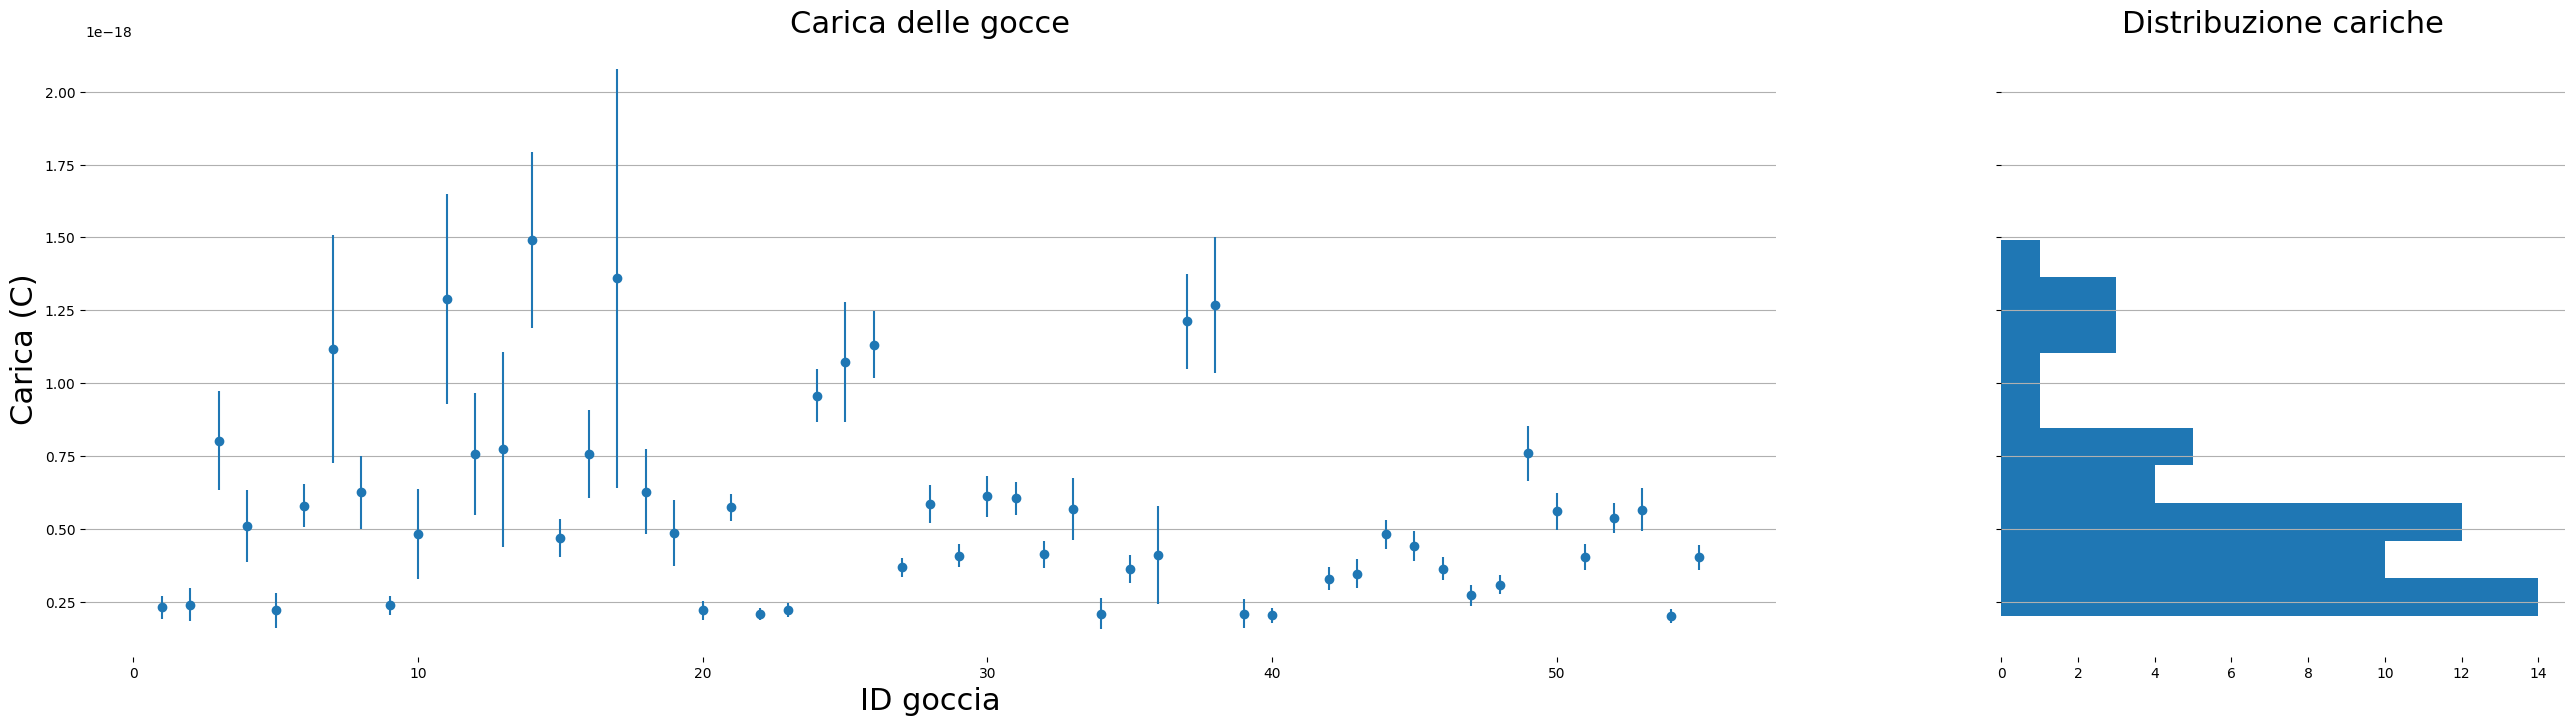

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (32,8), width_ratios=(3,1), sharey=True)
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xlabel('ID goccia', fontsize = 22)
ax1.set_ylabel('Carica (C)', fontsize = 22)
ax1.set_title('Carica delle gocce', fontsize=22)
ax1.errorbar(x=data.index ,y=data['carica'], yerr=data['err carica'], xerr=0, fmt='o')
ax2.grid(axis = 'y')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.xaxis.set_major_locator(plt.MultipleLocator(2))
ax2.set_title('Distribuzione cariche', fontsize=22)
ax2.hist(data['carica'], orientation = 'horizontal')
#plt.savefig('cariche.svg', bbox_inches = "tight")

(array([ 9.,  9.,  5., 12.,  4.,  2.,  4.,  4.,  3.,  2.]),
 array([372.31810435, 422.0636972 , 471.80929004, 521.55488289,
        571.30047574, 621.04606859, 670.79166143, 720.53725428,
        770.28284713, 820.02843997, 869.77403282]),
 <BarContainer object of 10 artists>)

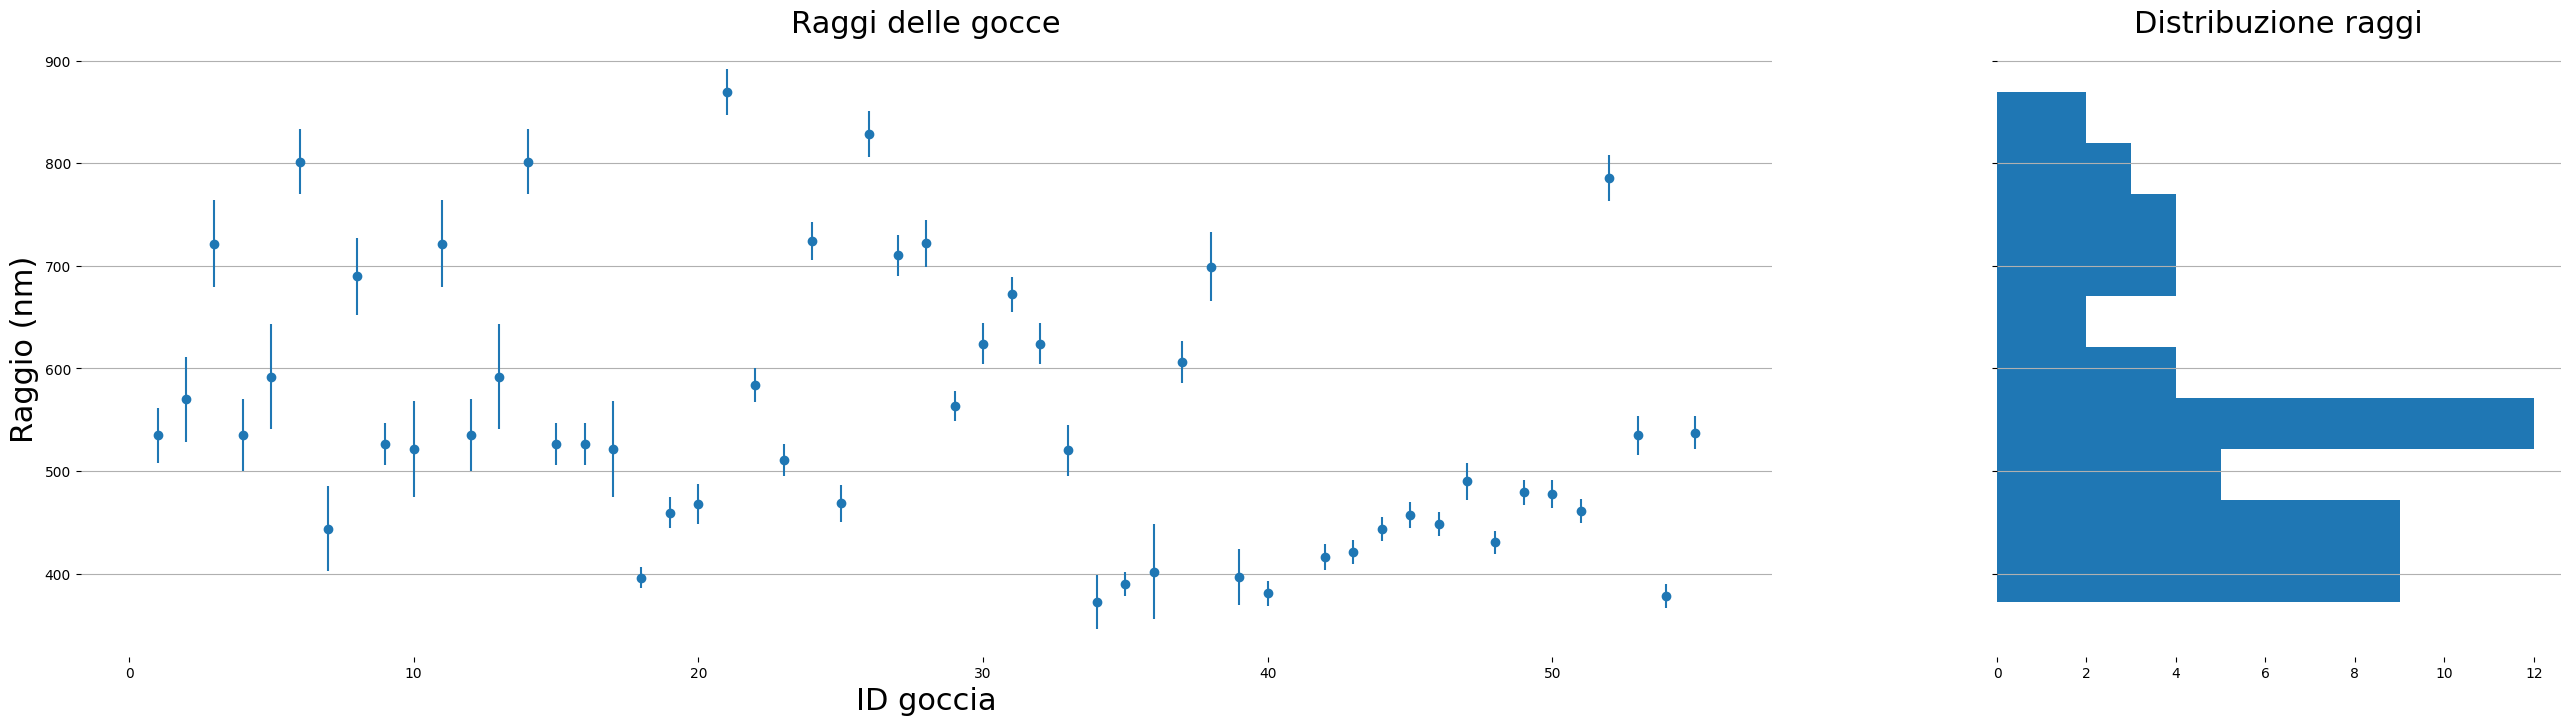

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (32,8), width_ratios=(3,1), sharey=True)
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xlabel('ID goccia', fontsize = 22)
ax1.set_ylabel('Raggio (nm)', fontsize = 22)
ax1.set_title('Raggi delle gocce', fontsize=22)
ax1.errorbar(x=data.index ,y=data['raggio']*1e9, yerr=data['err raggio']*1e9, xerr=0, fmt='o')
ax2.grid(axis = 'y')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.xaxis.set_major_locator(plt.MultipleLocator(2))
ax2.set_title('Distribuzione raggi', fontsize=22)
ax2.hist(data['raggio']*1e9, orientation = 'horizontal')
#plt.savefig('raggi.svg', bbox_inches = "tight")

In [12]:
data=data[data['err rel carica']<0.25]
differenze=np.array([abs(x[0]-x[1]) for x in combinations(data['carica'],2)])
differenze_s=np.array([x[0]-x[1] for x in permutations(data['carica'],2)])
lima=15*0.16e-19-0.16e-19/2
limb=5*0.16e-19+0.16e-19/2
mask1 = differenze < lima
mask2= differenze > limb
centro1, sigma1 = norm.fit(differenze[np.logical_and(mask1, mask2)])
print(centro1, sigma1)
mask10 = differenze_s < limb
mask20= differenze_s > -limb
centro0, sigma0 = norm.fit(differenze_s[np.logical_and(mask10, mask20)])
print(centro0, sigma0)

1.6110145139338694e-19 3.921758172457568e-20
4.585547486636276e-37 4.610815715084958e-20


<Axes: ylabel='Density'>

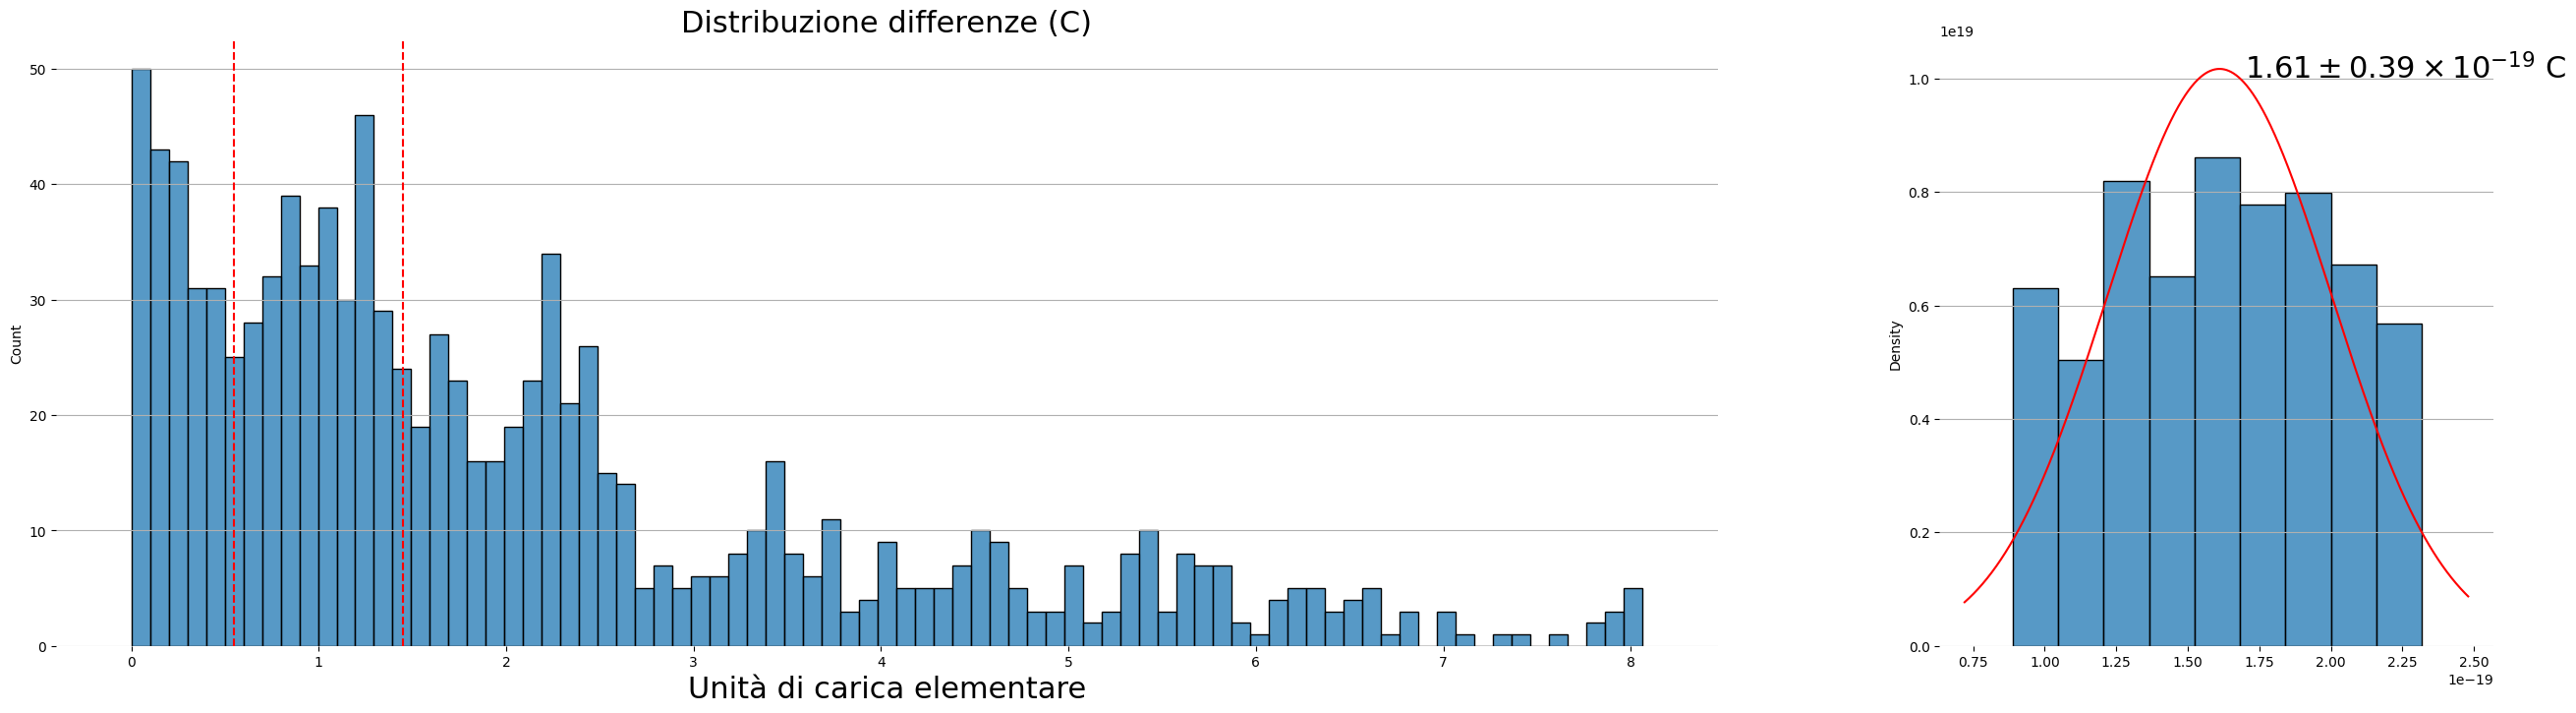

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2, figsize = (32,8), width_ratios=(3,1))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
sns.histplot(differenze/e, ax=ax1, binwidth=0.1)
ax1.axvline(x=limb/e, color='red', linestyle='--')
ax1.axvline(x=lima/e, color='red', linestyle='--')
ax1.set_xlabel('Unità di carica elementare', fontsize = 22)
ax1.set_title('Distribuzione differenze (C)', fontsize=22)
ax2.grid(axis = 'y')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.text(1.7e-19, 1e19, r'$1.61 \pm 0.39 \times 10^{-19}\ $C', fontsize=22)
sns.histplot(differenze[np.logical_and(mask1, mask2)], ax=ax2, binwidth=0.16e-19, stat='density')
x=np.linspace(limb-e*1e-1, lima+e*1e-1, 1000)
sns.lineplot(x=x, y=norm.pdf(x, loc=centro1, scale=sigma1), ax=ax2, color='red')
#plt.savefig('differenze.svg', bbox_inches = "tight")